In [64]:
!pip install -q pandas numpy scikit-learn matplotlib pyarrow openpyxl joblib

In [66]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import ExcelFile
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import joblib

# Jupyter plotting
%matplotlib inline
plt.style.use("seaborn-v0_8")

In [67]:
# ======== CONFIGURE THESE ========

# Your IEA Excel path (Windows)
EXCEL_PATH = r"C:\Users\JOSHUVA\OneDrive\Desktop\Projects\Ayka\EVDataExplorer2025.xlsx"

# Regions to model (we'll aggregate GCC from member countries)
FOCUS_REGIONS = ("India", "GCC")

# Forecast horizon (months ahead)
HORIZON = 12

# Market-share sim params
TARGET_SHARE = 0.15  # 15%
SCENARIO = "base"    # base | optimistic | conservative
BASE_CONV = 0.90     # capacity → deliveries conversion
CAPACITY  = 12000    # monthly production/delivery capacity

# ======== PROJECT FOLDERS (created under the current working dir) ========
BASE_DIR = Path.cwd()
RAW_DIR  = BASE_DIR / "data" / "raw"
PROC_DIR = BASE_DIR / "data" / "processed"
OUT_DIR  = BASE_DIR / "outputs"
FIG_DIR  = OUT_DIR / "figures"
MODEL_DIR= OUT_DIR / "models"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

OUT_CSV = RAW_DIR / "ev_market_real.csv"


In [68]:
# ---------- Helpers for flexible column detection ----------

ALIASES = {
    'region': {'region','country','geography','area','location','country/region'},
    'parameter': {'parameter','metric','indicator','series','variable','parameter name'},
    'mode': {'mode','vehicle type','vehicle_mode'},
    'powertrain': {'powertrain','technology','tech','power train'},
    'year': {'year','time','date','period'},
    'unit': {'unit','units'},
    'value': {'value','values','obs_value','observation value','data value'},
}

GCC_SET = {"Saudi Arabia","United Arab Emirates","Qatar","Oman","Bahrain","Kuwait"}

def _norm_cols(cols):
    def norm(c): return str(c).strip().lower().replace("\n"," ").replace("\r"," ").replace("  "," ")
    return [norm(c) for c in cols]

def _find_col(df, key):
    cands = ALIASES[key]
    for c in df.columns:
        if c in cands:
            return c
    for c in df.columns:
        for cand in cands:
            if cand in c:
                return c
    return None

def load_iea_excel_any_sheet(xlsx_path: Path):
    xls = ExcelFile(xlsx_path, engine="openpyxl")
    for sheet in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet, dtype=str)
        if df.empty:
            continue
        df.columns = _norm_cols(df.columns)
        if _find_col(df, 'value') is not None:
            return df, sheet
    raise ValueError("No suitable sheet with a numeric-like 'value' column found.")

def coerce_numeric(s): 
    return pd.to_numeric(s, errors="coerce")

def transform_iea_excel_to_project_csv(
    excel_path: Path,
    out_csv_path: Path,
    regions=("India","GCC"),
    make_gcc=True
) -> pd.DataFrame:
    df, used_sheet = load_iea_excel_any_sheet(excel_path)

    col_region = _find_col(df, 'region')
    col_param  = _find_col(df, 'parameter')
    col_mode   = _find_col(df, 'mode')         # optional
    col_pt     = _find_col(df, 'powertrain')   # optional
    col_year   = _find_col(df, 'year')
    col_unit   = _find_col(df, 'unit')         # optional
    col_value  = _find_col(df, 'value')

    missing = [n for n,c in [('region',col_region),('parameter',col_param),('year',col_year),('value',col_value)] if c is None]
    if missing:
        raise ValueError(f"Missing required columns in the Excel (sheet='{used_sheet}'): {missing}")

    work = df.copy()

    if col_mode is None:
        work["__mode"] = "Cars"
        col_mode = "__mode"
    if col_pt is None:
        work["__pt"] = "EV"
        col_pt = "__pt"

    # Keep cars / passenger
    work = work[
        work[col_mode].str.contains("car", case=False, na=False) |
        work[col_mode].str.contains("pass", case=False, na=False) |
        (work[col_mode].str.lower()=="cars")
    ]

    # Prefer EV sales; fallback to EV stock (we'll diff y/y)
    mask_sales = work[col_param].str.contains("ev sales", case=False, na=False)
    mask_stock = work[col_param].str.contains("ev stock", case=False, na=False)

    if mask_sales.any():
        sub = work[mask_sales].copy()
        using = "sales"
    elif mask_stock.any():
        sub = work[mask_stock].copy()
        using = "stock"
    else:
        # Assume sheet already represents EV sales
        sub = work.copy()
        using = "sales"

    # Filter to vehicle unit if unit column exists
    if col_unit and col_unit in sub.columns:
        sub = sub[sub[col_unit].str.contains("vehicle", case=False, na=False) | sub[col_unit].isna()]

    # Keep essentials
    sub = sub[[col_region, col_pt, col_year, col_value]].rename(
        columns={col_region:"region", col_pt:"powertrain", col_year:"year", col_value:"value"}
    )

    sub["year"] = coerce_numeric(sub["year"]).astype("Int64")
    sub["value"] = coerce_numeric(sub["value"])
    sub = sub.dropna(subset=["year","value"])
    sub["powertrain"] = sub["powertrain"].fillna("EV").str.upper().replace({
        "PLUG-IN HYBRID":"PHEV",
        "PLUG-IN HYBRID ELECTRIC VEHICLE":"PHEV",
        "BATTERY ELECTRIC":"BEV"
    })

    # If stock, convert to annual sales via y/y diff
    if using == "stock":
        sub = (sub.groupby(["region","powertrain","year"], as_index=False)["value"]
                  .sum().sort_values(["region","powertrain","year"]))
        sub["value"] = sub.groupby(["region","powertrain"])["value"].diff()
        sub = sub.dropna(subset=["value"])
        sub = sub[sub["value"] >= 0]

    # BEV + PHEV → total EV annual units
    annual = (sub.groupby(["region","year"], as_index=False)["value"]
                .sum().rename(columns={"value":"annual_units"}))

    # Aggregate GCC if individual members are present
    if make_gcc:
        gcc_part = annual[annual["region"].isin(GCC_SET)]
        if not gcc_part.empty:
            gcc = gcc_part.groupby("year", as_index=False)["annual_units"].sum()
            gcc.insert(0, "region", "GCC")
            annual = pd.concat(
                [annual[~annual["region"].isin(GCC_SET)], gcc],
                ignore_index=True
            )

    # Filter to requested regions
    if regions:
        keep = set(regions)
        annual = annual[annual["region"].isin(keep)]
        if annual.empty:
            raise ValueError(
                f"No rows left after filtering to {regions}. "
                f"Check region names in Excel (e.g., 'India', 'United Arab Emirates', etc.)."
            )

    # Expand annual → monthly (even split)
    rows = []
    for region, g in annual.groupby("region"):
        g = g.sort_values("year")
        g["year"] = pd.to_datetime(g["year"].astype(int), format="%Y")

        m = g.set_index("year").reindex(pd.date_range(g["year"].min(), g["year"].max(), freq="YS"))
        m["annual_units"] = m["annual_units"].interpolate()

        monthly = m.resample("MS").ffill()
        monthly["ev_units"] = (monthly["annual_units"] / 12.0).round().astype(int)

        monthly = monthly.reset_index().rename(columns={"index":"date"})
        monthly["region"] = region
        monthly["segment"] = "PV"
        rows.append(monthly[["date","region","segment","ev_units"]])

    final = pd.concat(rows, ignore_index=True)

    # Optional driver placeholders (model imputes)
    for c in ["price_index","infra_index","gdp_growth","policy_score"]:
        final[c] = pd.NA

    out_csv_path.parent.mkdir(parents=True, exist_ok=True)
    final.to_csv(out_csv_path, index=False)

    print(f"[OK] Wrote {out_csv_path} with {len(final):,} rows from sheet '{used_sheet}'.")
    return final

# ---- Run the transform ----
_ = transform_iea_excel_to_project_csv(Path(EXCEL_PATH), OUT_CSV, regions=FOCUS_REGIONS, make_gcc=True)

pd.read_csv(OUT_CSV).head()


[OK] Wrote C:\Users\JOSHUVA\anaconda_projects\19ce9158-4319-4346-bd15-92ecd3884648\data\raw\ev_market_real.csv with 241 rows from sheet 'GEVO_EV_2025'.


,date,region,segment,ev_units,price_index,infra_index,gdp_growth,policy_score
0,2010-01-01,India,PV,38,NaN,NaN,NaN,NaN
1,2010-02-01,India,PV,38,NaN,NaN,NaN,NaN
2,2010-03-01,India,PV,38,NaN,NaN,NaN,NaN
3,2010-04-01,India,PV,38,NaN,NaN,NaN,NaN
4,2010-05-01,India,PV,38,NaN,NaN,NaN,NaN


In [69]:
def add_time_features(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    df = df.copy()
    dt = pd.to_datetime(df[date_col])
    df["year"] = dt.dt.year
    df["month"] = dt.dt.month
    df["sin_month"] = np.sin(2 * np.pi * df["month"] / 12)
    df["cos_month"] = np.cos(2 * np.pi * df["month"] / 12)
    return df

def lag_features(df: pd.DataFrame, group_cols, target: str, lags=(1,2,3,6,12)) -> pd.DataFrame:
    df = df.sort_values([*group_cols, "date"]).copy()
    for L in lags:
        df[f"{target}_lag{L}"] = df.groupby(group_cols)[target].shift(L)
    return df

def load_raw(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    for c in ["price_index","infra_index","gdp_growth","policy_score"]:
        if c not in df.columns:
            df[c] = np.nan
    return df

raw = load_raw(OUT_CSV)

# Build features
fe = add_time_features(raw)
fe = lag_features(fe, ["region","segment"], "ev_units", lags=(1,2,3,6,12))
# drop first 12 months of each group (for lag availability)
fe = (fe.sort_values(["region","segment","date"])
        .groupby(["region","segment"])
        .apply(lambda g: g.iloc[12:])
        .reset_index(drop=True))

len(raw), len(fe), fe.head(3)


C:\Users\JOSHUVA\AppData\Local\Temp\ipykernel_20296\3072287130.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[12:])


(241,
 229,
         date region segment  ev_units  price_index  infra_index  gdp_growth  \
 0 2011-01-01  India      PV       117          NaN          NaN         NaN   
 1 2011-02-01  India      PV       117          NaN          NaN         NaN   
 2 2011-03-01  India      PV       117          NaN          NaN         NaN   
 
    policy_score  year  month  sin_month     cos_month  ev_units_lag1  \
 0           NaN  2011      1   0.500000  8.660254e-01           38.0   
 1           NaN  2011      2   0.866025  5.000000e-01          117.0   
 2           NaN  2011      3   1.000000  6.123234e-17          117.0   
 
    ev_units_lag2  ev_units_lag3  ev_units_lag6  ev_units_lag12  
 0           38.0           38.0           38.0            38.0  
 1           38.0           38.0           38.0            38.0  
 2          117.0           38.0           38.0            38.0  )

In [71]:
# Train/test split: last HORIZON months for holdout
fe = fe.sort_values("date")
unique_dates = fe["date"].sort_values().unique()
if len(unique_dates) <= HORIZON + 1:
    raise SystemExit("Not enough history for the requested horizon. Add more years or reduce HORIZON.")

cutoff = pd.Timestamp(unique_dates[-(HORIZON+1)])
train_df = fe[fe["date"] <= cutoff]
test_df  = fe[fe["date"] > cutoff]

y_train = train_df["ev_units"].values
y_test  = test_df["ev_units"].values

numeric = [
    "year","month","sin_month","cos_month",
    "price_index","infra_index","gdp_growth","policy_score",
    "ev_units_lag1","ev_units_lag2","ev_units_lag3","ev_units_lag6","ev_units_lag12"
]
categoricals = ["region","segment"]

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric),
    ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), categoricals),
])

model = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([("pre", pre), ("model", model)])
pipe.fit(train_df[numeric+categoricals], y_train)

test_pred = pipe.predict(test_df[numeric+categoricals])
mape = mean_absolute_percentage_error(y_test, test_pred)
print(f"Holdout MAPE: {mape:.2%}")

Holdout MAPE: 1.04%


C:\Users\JOSHUVA\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['price_index' 'infra_index' 'gdp_growth' 'policy_score']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\JOSHUVA\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['price_index' 'infra_index' 'gdp_growth' 'policy_score']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


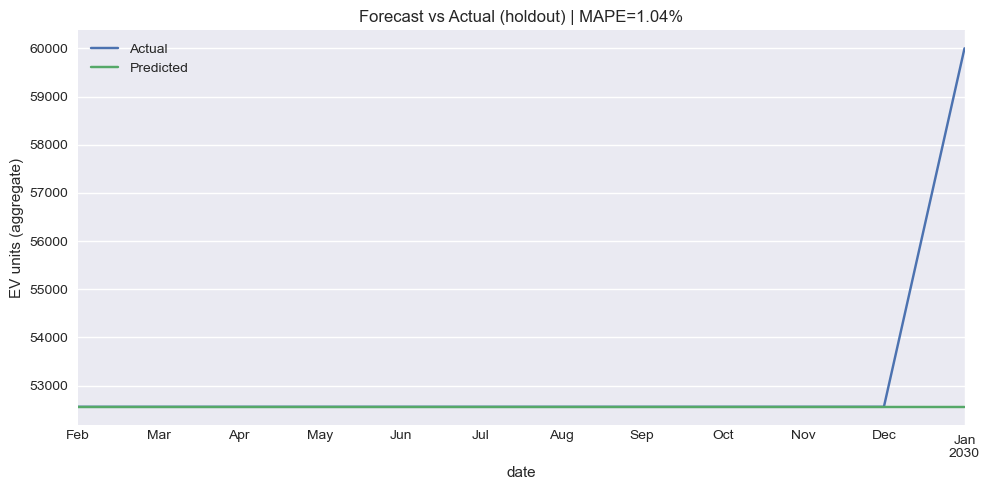

In [72]:
# Plot holdout performance (aggregate)
FIG_DIR.mkdir(parents=True, exist_ok=True)

agg_test = test_df.groupby("date")["ev_units"].sum()
agg_pred = pd.Series(test_pred, index=test_df["date"]).groupby(level=0).sum()

plt.figure(figsize=(10,5))
agg_test.plot(label="Actual")
agg_pred.plot(label="Predicted")
plt.title(f"Forecast vs Actual (holdout) | MAPE={mape:.2%}")
plt.ylabel("EV units (aggregate)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "forecast_vs_actual.png", dpi=160)
plt.show()

In [74]:
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, MODEL_DIR / "ev_forecast_model.pkl")

# Iterative HORIZON-month forecast per (region, segment)
last_date = fe["date"].max()
future_rows = []
groups = fe.groupby(["region","segment"], as_index=False)

for (region, segment), g in groups:
    g = g.sort_values("date").copy()
    current = g.copy()
    for h in range(1, HORIZON+1):
        d = (last_date + pd.offsets.MonthBegin(h)).to_pydatetime()
        row = {"date": pd.Timestamp(d), "region": region, "segment": segment}
        tmp = pd.DataFrame([row])

        # carry last row's features, update date/keys
        tmp = (pd.concat([current.tail(1).drop(columns=["ev_units"]).reset_index(drop=True)
                          .assign(date=row["date"], region=region, segment=segment), tmp],
                         ignore_index=True).tail(1))
        # add time features
        tmp = add_time_features(tmp)

        # simple driver drift (safe if NaN → start at 0)
        last = current.tail(1)
        for col, drift in [("price_index",0.2), ("infra_index",0.6), ("gdp_growth",0.02), ("policy_score",0.1)]:
            base = float(last[col]) if pd.notna(last[col].values[0]) else 0.0
            tmp[col] = base + drift

        # lags from last known ev_units
        for L in [1,2,3,6,12]:
            tmp[f"ev_units_lag{L}"] = current["ev_units"].tail(1).values[0]

        yhat = pipe.predict(tmp[[
            "year","month","sin_month","cos_month","price_index","infra_index","gdp_growth","policy_score",
            "region","segment","ev_units_lag1","ev_units_lag2","ev_units_lag3","ev_units_lag6","ev_units_lag12"
        ]])[0]

        tmp_out = tmp.assign(ev_units=max(0, yhat))
        current = pd.concat([current, tmp_out[current.columns]], ignore_index=True)

    future_rows.append(current[current["date"] > last_date])

future_df = pd.concat(future_rows, ignore_index=True)

PROC_DIR.mkdir(parents=True, exist_ok=True)
fe.to_parquet(PROC_DIR / "ev_features.parquet")
future_df.to_parquet(PROC_DIR / "ev_forecast.parquet")

len(future_df), future_df.head(3)

C:\Users\JOSHUVA\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['price_index' 'infra_index' 'gdp_growth' 'policy_score']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\JOSHUVA\AppData\Local\Temp\ipykernel_20296\593173104.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base = float(last[col]) if pd.notna(last[col].values[0]) else 0.0
C:\Users\JOSHUVA\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['price_index' 'infra_index' 'gdp_growth' 'policy_score']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\JOSHUVA\AppData\Local\Temp\ipykernel_20296\593173104.py:27: FutureWarning: Calling float on a single element Series is deprecated a

(12,
         date region segment      ev_units  price_index  infra_index  \
 0 2030-02-01  India      PV  52554.444628          0.2          0.6   
 1 2030-03-01  India      PV  52554.444628          0.4          1.2   
 2 2030-04-01  India      PV  52554.444628          0.6          1.8   
 
    gdp_growth  policy_score  year  month  sin_month     cos_month  \
 0        0.02           0.1  2030      2   0.866025  5.000000e-01   
 1        0.04           0.2  2030      3   1.000000  6.123234e-17   
 2        0.06           0.3  2030      4   0.866025 -5.000000e-01   
 
    ev_units_lag1  ev_units_lag2  ev_units_lag3  ev_units_lag6  ev_units_lag12  
 0   60000.000000   60000.000000   60000.000000   60000.000000    60000.000000  
 1   52554.444628   52554.444628   52554.444628   52554.444628    52554.444628  
 2   52554.444628   52554.444628   52554.444628   52554.444628    52554.444628  )

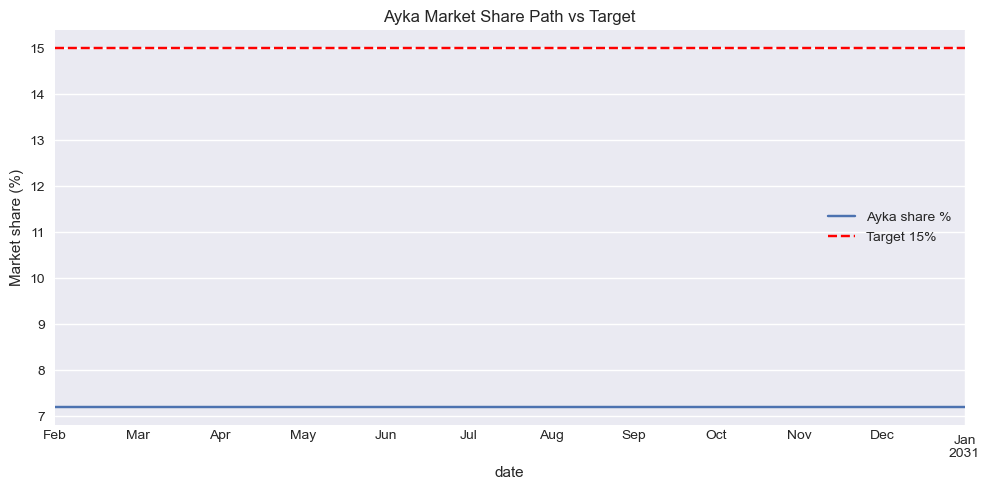

Saved: C:\Users\JOSHUVA\anaconda_projects\19ce9158-4319-4346-bd15-92ecd3884648\outputs\figures\market_share_path.png and C:\Users\JOSHUVA\anaconda_projects\19ce9158-4319-4346-bd15-92ecd3884648\outputs\market_share_summary.csv


In [76]:
def scenario_multipliers(scenario: str):
    if scenario == "optimistic":
        return {"price": 0.98, "infra": 1.05, "policy": 1.03}
    if scenario == "conservative":
        return {"price": 1.02, "infra": 0.97, "policy": 0.98}
    return {"price": 1.00, "infra": 1.00, "policy": 1.00}

def apply_scenario(df: pd.DataFrame, scenario: str) -> pd.DataFrame:
    m = scenario_multipliers(scenario)
    out = df.copy()
    for c in ["price_index","infra_index","policy_score"]:
        if c not in out.columns:
            out[c] = 0.0
    out[["price_index","infra_index","policy_score"]] = out[["price_index","infra_index","policy_score"]].fillna(0.0)

    # Simple demand multiplier
    driver_effect = (
        (1 - 0.002*(out["price_index"]*m["price"] - 100)) *
        (1 + 0.003*(out["infra_index"]*m["infra"] - 60)) *
        (1 + 0.001*(out["policy_score"]*m["policy"] - 50))
    )
    out["ev_units_adj"] = (out["ev_units"] * driver_effect).clip(lower=0)
    return out

def ayka_sales_ramp(df: pd.DataFrame, base_conv: float, capacity: int):
    """
    df must have: date, region, segment, ev_units_adj
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    if "segment" not in df.columns:
        df["segment"] = "PV"

    # Total market per date
    total_market = df.groupby("date")["ev_units_adj"].sum().rename("market")
    df = df.merge(total_market, on="date")

    # Pre-constraint attainable demand
    df["ayka_demand"] = 0.08 * df["ev_units_adj"]

    # Proportional capacity split across segments per date (robust to zero totals)
    alloc = (df.groupby(["date","segment"], as_index=False)["ayka_demand"].sum())
    alloc["capacity_alloc"] = alloc.groupby("date")["ayka_demand"].transform(
        lambda s: (capacity * (s / s.sum())) if s.sum() > 0 else (s*0)
    )
    alloc = alloc[["date","segment","capacity_alloc"]]

    df = df.merge(alloc, on=["date","segment"], how="left")
    df["ayka_sales"] = np.minimum(df["ayka_demand"], df["capacity_alloc"]).fillna(0) * base_conv

    share = (
        df.groupby("date")["ayka_sales"].sum()
        / df.groupby("date")["ev_units_adj"].sum()
    ).rename("share")

    return df, share

# Apply scenario and compute share path
fut = future_df.copy()
fut = apply_scenario(fut, SCENARIO)
df_ms, share = ayka_sales_ramp(fut, base_conv=BASE_CONV, capacity=CAPACITY)

plt.figure(figsize=(10,5))
(share*100).plot(label="Ayka share %")
plt.axhline(TARGET_SHARE*100, color="red", linestyle="--", label=f"Target {TARGET_SHARE*100:.0f}%")
plt.title("Ayka Market Share Path vs Target")
plt.ylabel("Market share (%)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "market_share_path.png", dpi=160)
plt.show()

# Save summary
share.reset_index().rename(columns={"share":"share"}).to_csv(OUT_DIR / "market_share_summary.csv", index=False)
print("Saved:", FIG_DIR / "market_share_path.png", "and", OUT_DIR / "market_share_summary.csv")

In [77]:
# Tidy snapshot of the monthly demand used for modeling
monthly_csv = OUT_DIR / "ev_monthly_modeled.csv"
pd.read_csv(OUT_CSV).to_csv(monthly_csv, index=False)
monthly_csv, (FIG_DIR / "forecast_vs_actual.png"), (FIG_DIR / "market_share_path.png")

(WindowsPath('C:/Users/JOSHUVA/anaconda_projects/19ce9158-4319-4346-bd15-92ecd3884648/outputs/ev_monthly_modeled.csv'),
 WindowsPath('C:/Users/JOSHUVA/anaconda_projects/19ce9158-4319-4346-bd15-92ecd3884648/outputs/figures/forecast_vs_actual.png'),
 WindowsPath('C:/Users/JOSHUVA/anaconda_projects/19ce9158-4319-4346-bd15-92ecd3884648/outputs/figures/market_share_path.png'))